# Simulering Bemanning og Skiftdesign

**2. Simulering av bemanningsbehov og skiftdesign**<br>
<br>
**Formål**: Beregne bemanningsbehovet basert på forventet antall pasienter og skifttider, og sammenligne dette med eksisterende bemanning.<br>
**Hvordan**: Bruk data om pasientankomster og gjennomsnittlig liggetid til å forutsi antall pasienter på avdelingen til ulike tider av døgnet. Deretter sammenligner du dette med nåværende skiftdesign og bemanning for å identifisere under- eller overdekning.<br>
**Resultat**: Avdekke perioder hvor bemanningen er for lav, og evaluere hvordan skiftplanlegging kan optimaliseres.<br>

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Formål**: Simulere bemanningsbehov basert på pasientvolum, skiftplaner og kapasitet.<br>
<br>
**Nødvendig data**:<br>
<br>
1. Antall pasientankomster per time/dag.<br>
2. Skifttider for helsepersonell.<br>
3. Krav til bemanning per pasient (f.eks. antall sykepleiere per pasient).<br>

In [2]:
def datalast_behandling(path: str) -> pd.DataFrame:
    fin_hf_med = pd.read_excel(path, sheet_name = "medisinsk hammerfest")
    fin_hf_kir_ort = pd.read_excel(path, sheet_name = "kirurgisk hammerfest")

    # post kolonne
    fin_hf_med["post"] = "medisinsk"
    fin_hf_kir_ort["post"] = "kirurgisk"

    # merge and order datasets
    fin_data = pd.concat([fin_hf_med, fin_hf_kir_ort], axis=0).sort_values("Dato").reset_index()
    fin_data.drop(["index"], axis=1, inplace=True)
    fin_data['helg'] = fin_data['Dato'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)
    return fin_data

In [4]:
path = "../data/fin_hf_datagrunnlag.xlsx"
fin_data = datalast_behandling(path)

## Input data

In [5]:
data = fin_data
post = "medisinsk"
weekend = False
predictions = "False"
year = 2023
avg_length_of_stay = 3  # Gjennomsnittlig liggetid (dager)
patients_per_nurse = 3  # Antall pasienter per sykepleier
shifts_per_day = 3  # Antall skift per dag
iterations = 1000  # Antall simuleringer

## Simulering underbemannede skift

In [6]:
def over_under_staffed_shifts(data: pd.DataFrame, avg_length_of_stay: int, patients_per_nurse: int, shifts_per_day: int, iterations: int, post: str, weekend: bool = False, predictions: bool = False, year: int = 2024):
    if post == "medisinsk":
        df_fin = data[data["post"] == "medisinsk"]
    elif post == "kirurgisk":
        df_fin = data[data["post"] == "kirurgisk"]
    
    if weekend == True:
        df_fin = df_fin[df_fin["helg"] == 1]
    else:
        df_fin = df_fin[df_fin["helg"] == 0]

    if predictions == True:
        df_fin = df_fin[df_fin["År"] == 2025]
    else:
        df_fin = df_fin[df_fin["År"] == year]
    
    df_fin = df_fin.reset_index()
    df_index = df_fin.index.values
    df_index = [x +1 for x in df_index]
    df_fin["day of year"] = df_index
    
    understaffed_shifts = 0
    overstaffed_shifts = 0
    total_shifts = 0
    staffed_shifts_data = []

    for _ in range(iterations):
        yearly_understaffed_shifts = 0  # Teller hvor mange skift per år med underbemanning
        yearly_overstaffed_shifts = 0  # Teller hvor mange skift per år med overbemanning
        patients_on_ward = []  # Liste for å holde oversikt over pasienter som allerede ligger inne
        
        for index, row in df_fin.iterrows(): 
            new_admissions = row["Antall inn på post"]  # Simulerer nye pasienter
            lengths_of_stay = np.random.exponential(avg_length_of_stay, new_admissions)  # Simulerer liggetider

            # Legg til nye pasienter som skal legges inn
            patients_on_ward.extend(lengths_of_stay)
            
            # Oppdater liggetidene for pasienter som allerede er inne
            patients_on_ward = [stay - 1 for stay in patients_on_ward]  # Reduserer liggetiden med 1 for hver dag
            patients_on_ward = [stay for stay in patients_on_ward if stay > 0]  # Fjern pasienter som er utskrevet

            # Beregn total antall pasienter som trenger pleie i dag
            total_patients = len(patients_on_ward)

            # Beregn antall sykepleiere som trengs per skift
            nurses_needed_per_shift = total_patients / patients_per_nurse / shifts_per_day

            actual_nurses = 6  # Faktisk antall sykepleiere per skift

            # Simuler skiftene for dagen
            for shift in range(shifts_per_day):
                total_shifts += 1  # Oppdater totalt antall skift
                if nurses_needed_per_shift > actual_nurses:
                    understaffed_shifts += 1  # Underbemanning i dette skiftet
                    yearly_understaffed_shifts += 1  # Tell daglig underbemanning
                elif nurses_needed_per_shift < actual_nurses:
                    overstaffed_shifts += 1
                    yearly_overstaffed_shifts += 1
                staffed_shifts_data.append(nurses_needed_per_shift)
    return understaffed_shifts, overstaffed_shifts, total_shifts, staffed_shifts_data

understaffed_shifts, overstaffed_shifts, total_shifts, staffed_shifts_data = over_under_staffed_shifts(data, avg_length_of_stay, patients_per_nurse, shifts_per_day, iterations, post, weekend, predictions, year)


prosent_underbemannet_skift = understaffed_shifts / total_shifts * 100
prosent_overbemannet_skift = overstaffed_shifts / total_shifts * 100

# Resultat: Hvor ofte er skift underbemannet?
print(f"Prosentandel skift med underbemanning: {prosent_underbemannet_skift:.2f}%")
print(f"Prosentandel skift med overbemanning: {prosent_overbemannet_skift:.2f}%")
print(f"Prosentandel skift med riktig bemanning: {(100 - (prosent_underbemannet_skift + prosent_overbemannet_skift)):.2f}%")

# Sjekk om det har vært underbemanning i løpet av året
# print(f"Underbemannede skift i dette året: {yearly_understaffed_shifts}")
# print(f"Underbemannede skift i dette året (i %): {round((yearly_understaffed_shifts/total_shifts)*100,2)}%")
# print(f"Overbemannede skift i dette året: {yearly_overstaffed_shifts}")
# print(f"Overbemannede skift i dette året (i %): {round((yearly_overstaffed_shifts/total_shifts)*100,2)}%")

Prosentandel skift med underbemanning: 0.00%
Prosentandel skift med overbemanning: 100.00%
Prosentandel skift med riktig bemanning: 0.00%


## Resultater

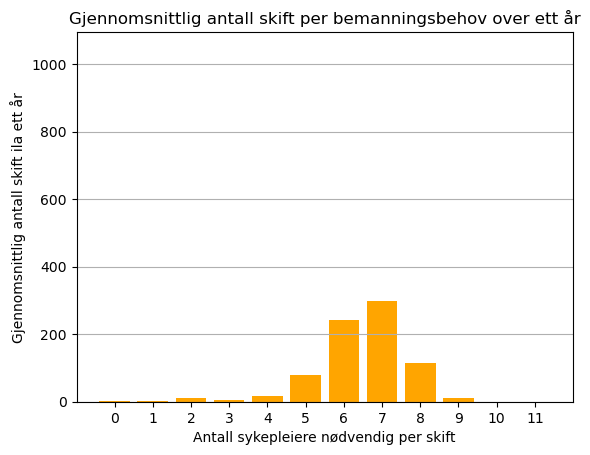

In [18]:
def under_over_staffing_plot(staffed_shifts_data, iterations, shifts_per_day):
    # Forbered data for visualisering
    max_nurses_needed = int(max(staffed_shifts_data)) + 1  # Finn maksimum nødvendig sykepleiere
    shift_counts = [0] * max_nurses_needed  # Liste for å telle antall skift for hver sykepleier
    for nurses_needed in staffed_shifts_data:
        shift_counts[int(nurses_needed)] += 1

    # Konverter til gjennomsnitt over alle simuleringer
    average_shifts_needed = [count / iterations for count in shift_counts]

    # Visualisering av gjennomsnittlig bemanningsbehov
    plt.bar(range(max_nurses_needed), average_shifts_needed, color='orange')
    plt.xlabel('Antall sykepleiere nødvendig per skift')
    plt.ylabel('Gjennomsnittlig antall skift ila ett år')
    plt.title('Gjennomsnittlig antall skift per bemanningsbehov over ett år')
    plt.xticks(range(0, max_nurses_needed, 1))  # Vis alle unike verdier på x-aksen
    plt.ylim(0, 365 * shifts_per_day)  # Sett y-aksen opp til maksimalt antall skift i året
    plt.grid(axis='y')
    plt.show()

under_over_staffing_plot(staffed_shifts_data, iterations, shifts_per_day)

**Verdi for sykehuset**:<br>
<br>
1. Forstå hvor ofte avdelingen kan ha for lav bemanning.<br>
2. Planlegge bemanning bedre ved å bruke data om faktiske pasientbehov.<br>